In [1]:
from scipy.fft import fft, ifft, fftfreq, fftshift
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#чтение спектра из файла

#out_wl -индикатор выводы массива длин волн

def read_spectr(file_name, out_wl = 1):
    lamda, spectrum = [], []
    with open(file_name, 'r') as f:
        for line in f.readlines()[2:]:
            col1, col2 = line.split()
            lamda.append(float(col1)/1000), spectrum.append(10**((float(col2)+120)/10))
    f.close()
    if out_wl == 1:
        return np.array(lamda), np.array(spectrum)
    else:
        return np.array(spectrum)

In [3]:
#сглаживающая функция

#box_pts - количесвто элементов в сглаживании 

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [4]:
#интерполлирующие функции для увеличения разрешения OSA

def f_line(a, b, res):
    return [np.round(a + (b-a)*i/res, 5) for i in range(res)] #res - количество точек между исходными, включая границы

#dl - количесвто новых точек на отрезке между двумя первоначальными 
def interpolate(l_in, dl):
    l_out = []
    for i in range(len(l_in)-1):
        l_out.extend(f_line(l_in[i], l_in[i+1], dl))
    l_out.append(l_in[-1])
    return np.array(l_out)

In [101]:
#Фурье преобразование

#spectr_initial, spectr_new - начальный спектр и с интреференцией
#wo_noise1, wo_noise2 - диапазон элементов массива длин волн wavelength_mas где нет сильных шумов
#out - интдикатор вывода массивов фурье элементов

def fourier(wavelength_mas, spectr_initial, spectr_new, wo_noise1, wo_noise2, out = 0, max = 0.005, color = 'm'):
    
    N = len(wavelength_mas)-1 
    k = np.linspace(1/wavelength_mas[-1], 1/wavelength_mas[0], N, endpoint=False)

    ##############Выборка шумов#################
    noise_a, noise_b  = wo_noise1, wo_noise2

    Nd = noise_b - noise_a - 1
    xd = k[noise_a:noise_b]
    Td = (k[noise_b] - k[noise_a]) / Nd 
    xdf = fftfreq(Nd, Td)[:Nd//2]

    #функция интерференции
    y = (spectr_new/spectr_initial)[noise_a:noise_b]

    #Fourier function
    yf = ifft(y)
    yf_abs = 2.0/Nd * np.abs(yf[0:Nd//2])

    ###############################################

    
    plt.plot(xdf, yf_abs, '-'+color)
    plt.title('Fourier Domain')
    plt.xlabel('$\Delta$z, um')
    plt.ylabel('Amplitude, a.u')
    plt.ylim([0, max])
    plt.grid()
    plt.show()
    if out == 1:
        return xdf, yf_abs

# ПРИМЕР

In [51]:
%matplotlib qt
fourier(wl, s_01, s_int_1, 2800, 4000)

# SNR

# MIrror 28.03

In [45]:
#unpack files
import os
path = "C:/Users/User/Documents/Python/28.03. mirror/"
for root, dirs, files in os.walk(path):
    continue

In [104]:
#initial spectrum
#1000_no sample_2023_03_28_17_42_48.dat
#spectrum_with_ampl_2023_03_14_14_17_16.dat
a = 2 #EXTRA RESOLUTION
wl0, sp_init0 = read_spectr('spectrum_with_ampl_2023_03_14_14_17_16.dat')
sp_init = interpolate(sp_init0, a)
wl = interpolate(wl0, a)

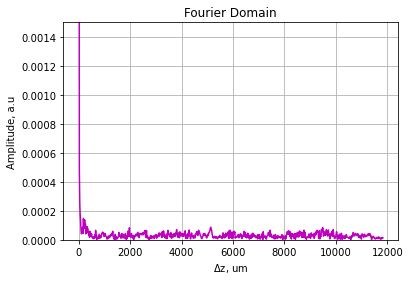

distance between fibers = 17500, or 1000 counts


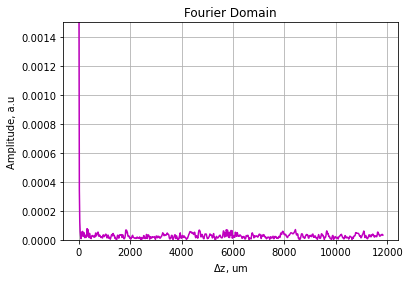

distance between fibers = 17500, or 1000 counts


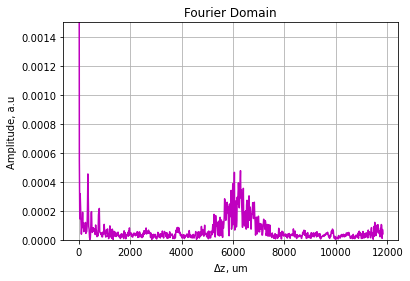

distance between fibers = 10500, or 2400 counts


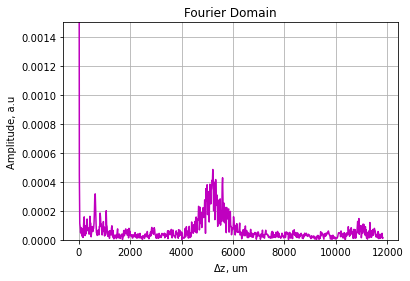

distance between fibers = 10000, or 2500 counts


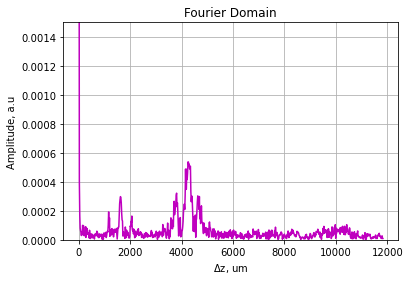

distance between fibers = 9500, or 2600 counts


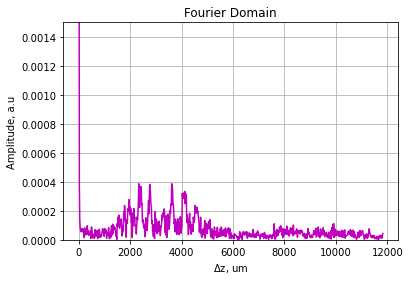

distance between fibers = 9000, or 2700 counts


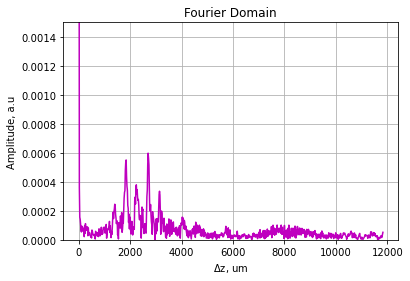

distance between fibers = 8500, or 2800 counts


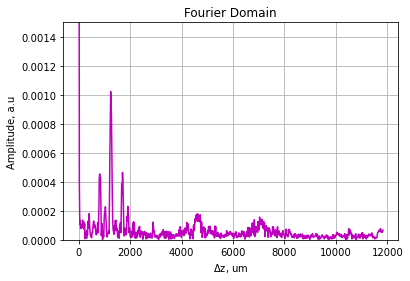

distance between fibers = 8000, or 2900 counts


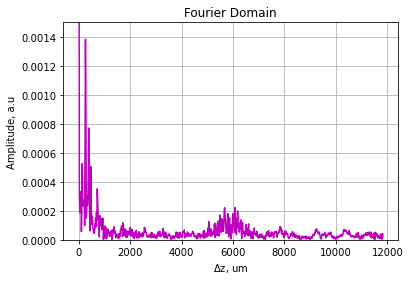

distance between fibers = 7500, or 3000 counts


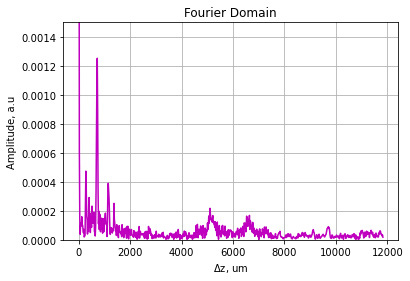

distance between fibers = 7000, or 3100 counts


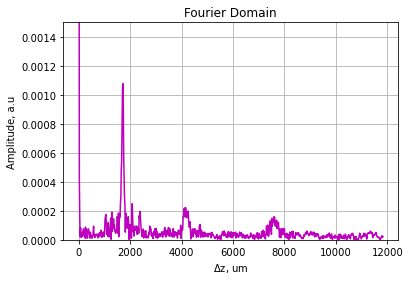

distance between fibers = 6500, or 3200 counts


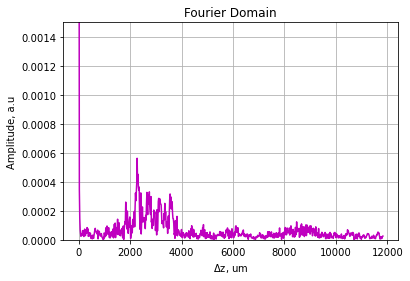

distance between fibers = 6000, or 3300 counts


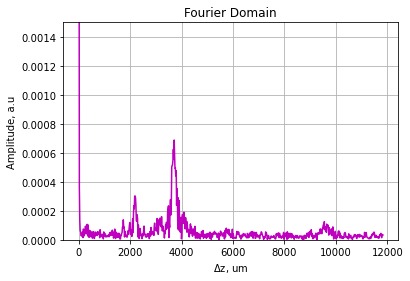

distance between fibers = 5500, or 3400 counts


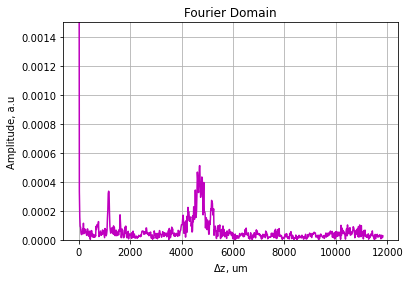

distance between fibers = 5000, or 3500 counts


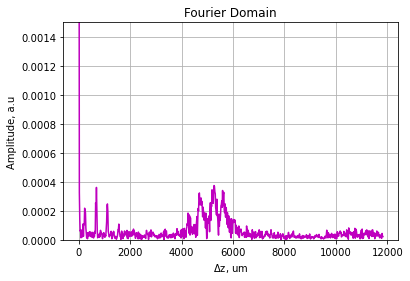

distance between fibers = 4750, or 3550 counts


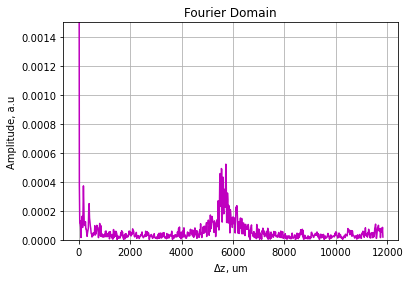

distance between fibers = 4500, or 3600 counts


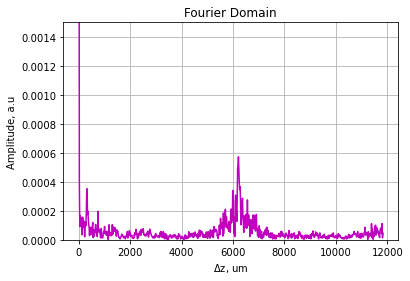

distance between fibers = 4250, or 3650 counts


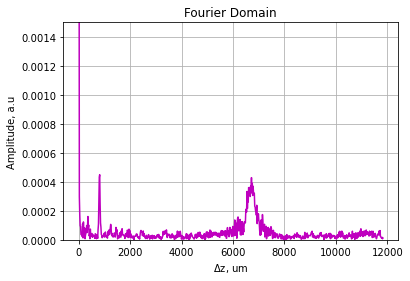

distance between fibers = 4000, or 3700 counts


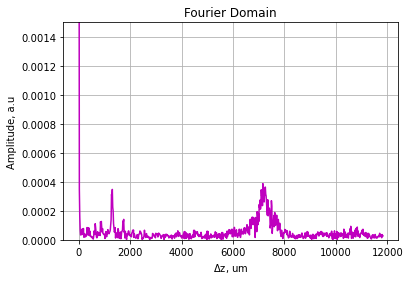

distance between fibers = 3750, or 3750 counts


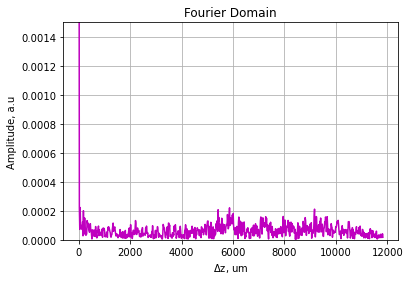

distance between fibers = 3500, or 3800 counts


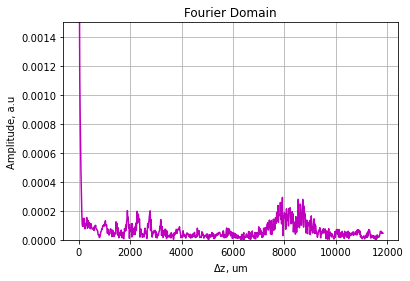

distance between fibers = 3250, or 3850 counts


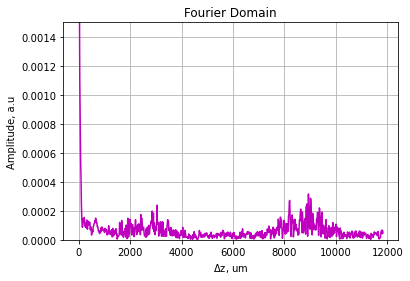

distance between fibers = 3000, or 3900 counts


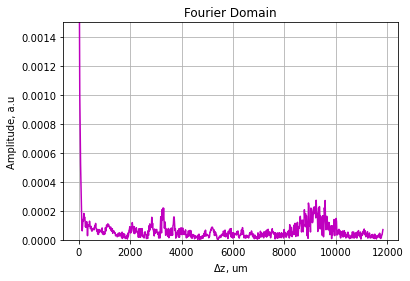

distance between fibers = 2750, or 3950 counts


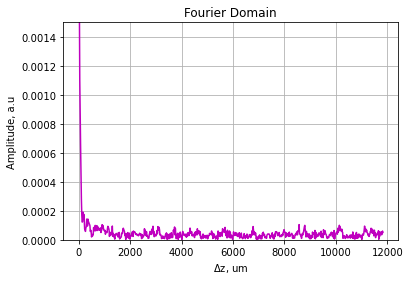

distance between fibers = 2500, or 4000 counts


In [102]:
#interference
for name in files:
    sp = read_spectr(path+name, out_wl=0)
    sp = interpolate(sp, int(a/2))
    distance = int(name[:4])
    fourier(wl, sp_init, sp, int(len(wl)*1/8), int(len(wl)*7/8), out = 0, max = 0.0015)
    print(f'distance between fibers = {22500 - distance*5}, or {distance} counts')

# Тоже самое, но разрешение лучше (искуссвенно увеличено разбиение)

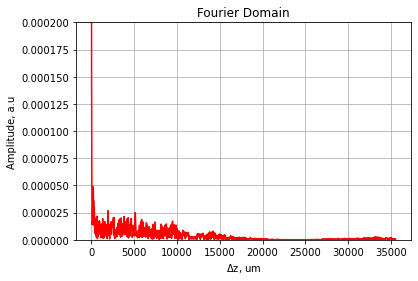

distance between fibers = 17500, or 1000 counts


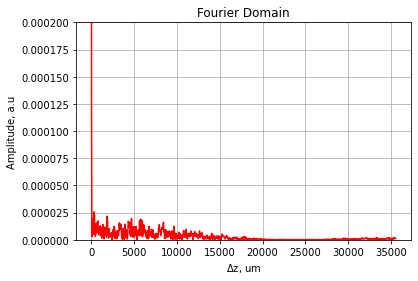

distance between fibers = 17500, or 1000 counts


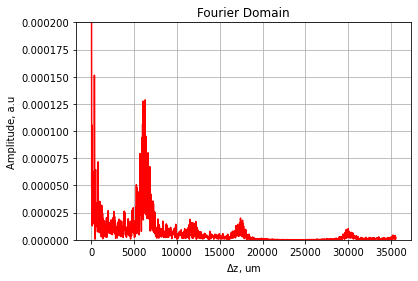

distance between fibers = 10500, or 2400 counts


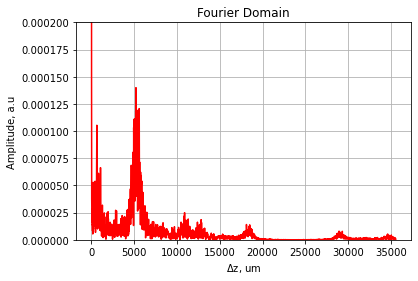

distance between fibers = 10000, or 2500 counts


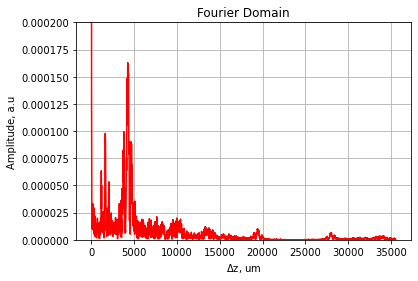

distance between fibers = 9500, or 2600 counts


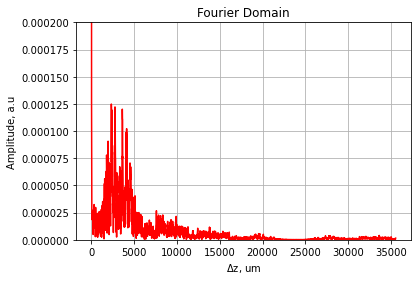

distance between fibers = 9000, or 2700 counts


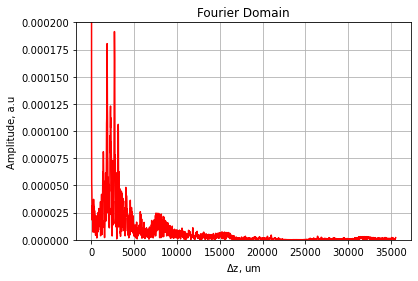

distance between fibers = 8500, or 2800 counts


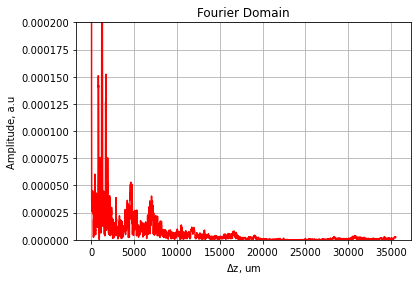

distance between fibers = 8000, or 2900 counts


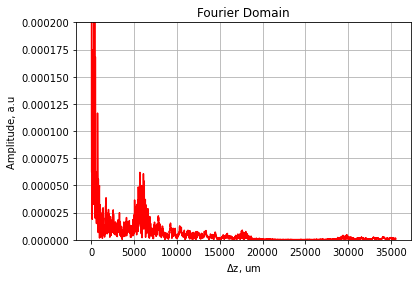

distance between fibers = 7500, or 3000 counts


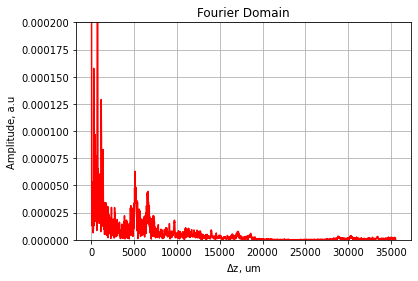

distance between fibers = 7000, or 3100 counts


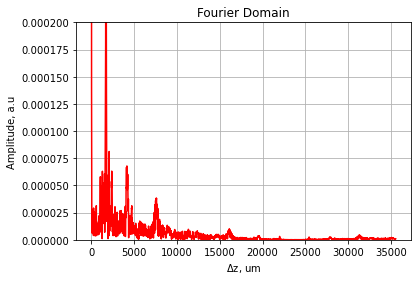

distance between fibers = 6500, or 3200 counts


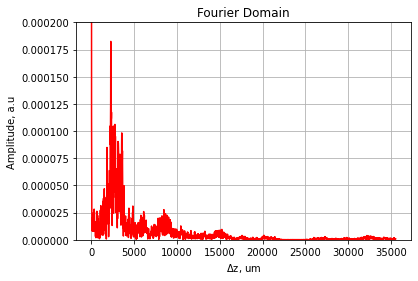

distance between fibers = 6000, or 3300 counts


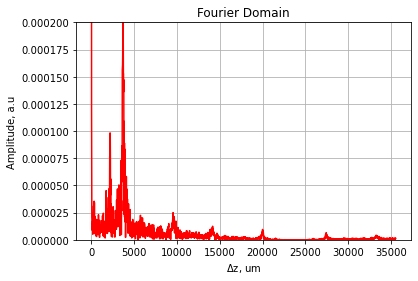

distance between fibers = 5500, or 3400 counts


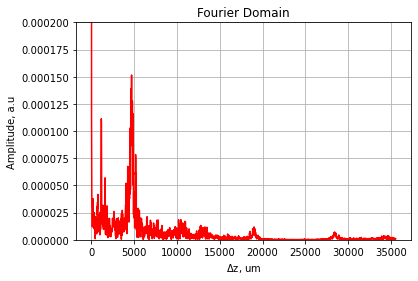

distance between fibers = 5000, or 3500 counts


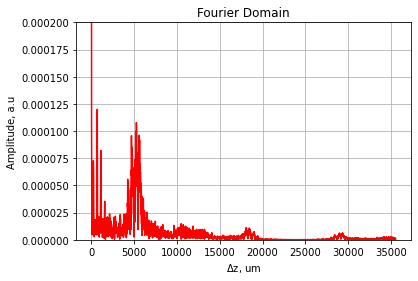

distance between fibers = 4750, or 3550 counts


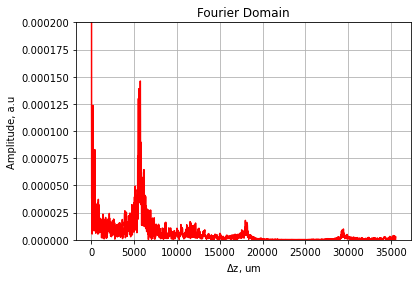

distance between fibers = 4500, or 3600 counts


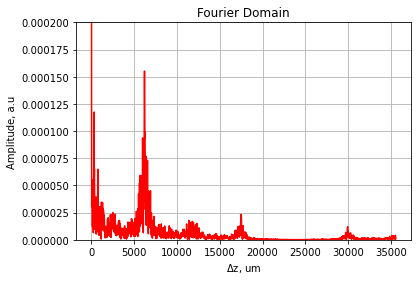

distance between fibers = 4250, or 3650 counts


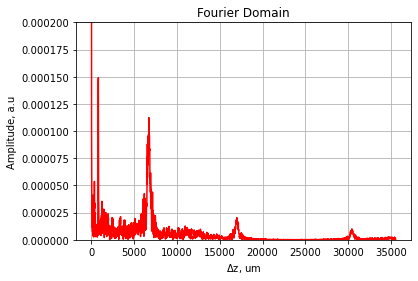

distance between fibers = 4000, or 3700 counts


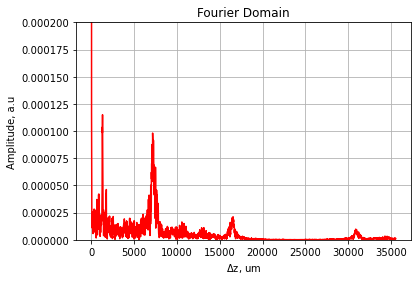

distance between fibers = 3750, or 3750 counts


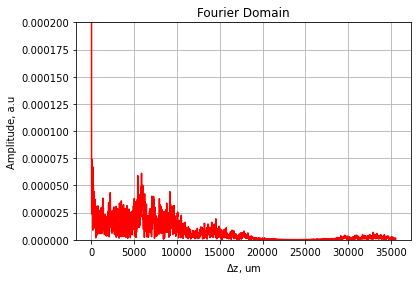

distance between fibers = 3500, or 3800 counts


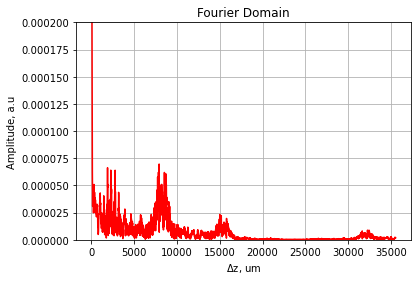

distance between fibers = 3250, or 3850 counts


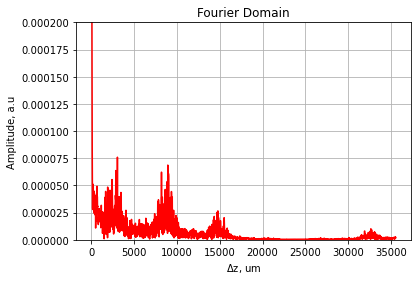

distance between fibers = 3000, or 3900 counts


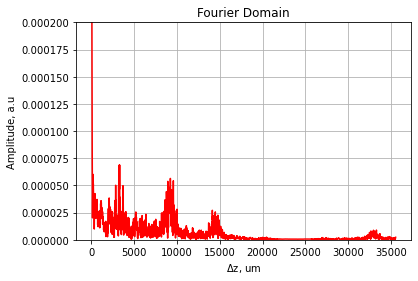

distance between fibers = 2750, or 3950 counts


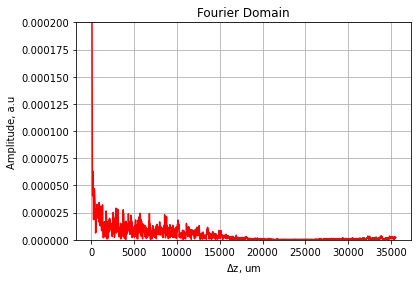

distance between fibers = 2500, or 4000 counts


In [110]:
a = 6
sp_init = interpolate(sp_init0, a)
wl = interpolate(wl0, a)

#interference
for name in files:
    sp = read_spectr(path+name, out_wl=0)
    sp = interpolate(sp, int(a/2))
    distance = int(name[:4])
    fourier(wl, sp_init, sp, int(len(wl)*1/8), int(len(wl)*7/8), out = 0, max = 0.0002, color = 'r')
    print(f'distance between fibers = {22500 - distance*5}, or {distance} counts')

# Mirror

In [54]:
#unpack files
import os
path = "C:/Users/User/Documents/Python/21.03 mirror/"
for root, dirs, files in os.walk(path):
    continue

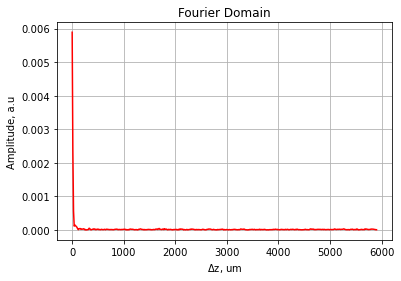

z = 15000


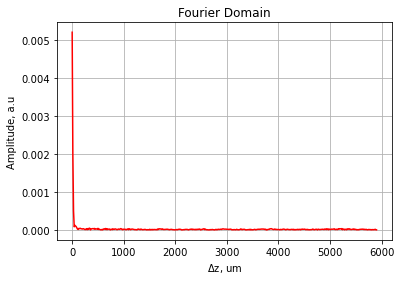

z = 12500


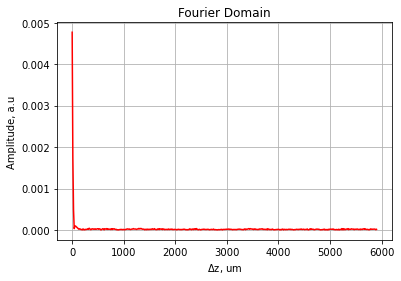

z = 10000


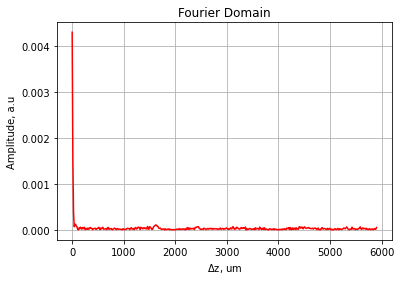

z = 7500


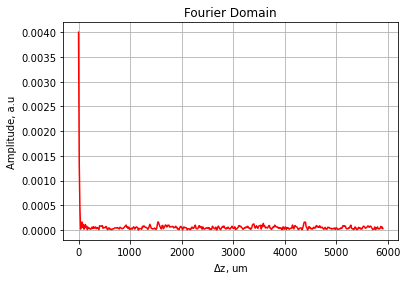

z = 5000


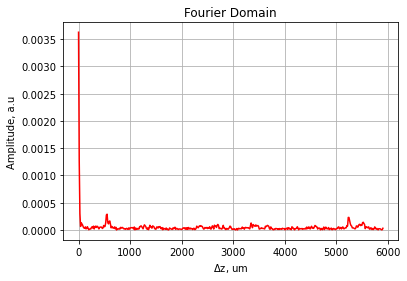

z = 4000


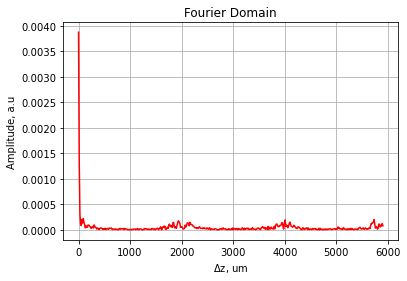

z = 3750


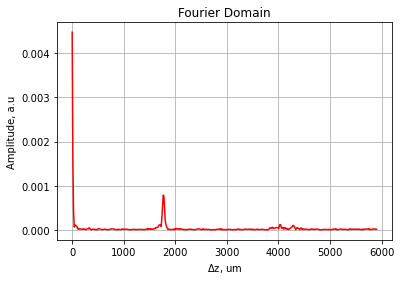

z = 2500


In [55]:
#interference
for name in files:
    sp = read_spectr(path+name, out_wl=0)
    distance = int(name[:4])
    fourier(wl, sp_init, sp, 50, 950, out = 0)
    print('z =', 22500 - distance*5)

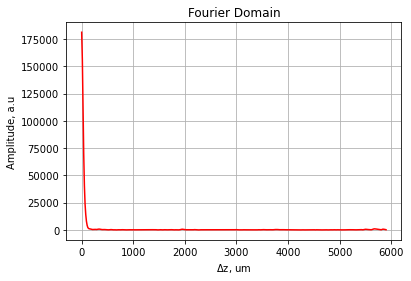

z = 15000


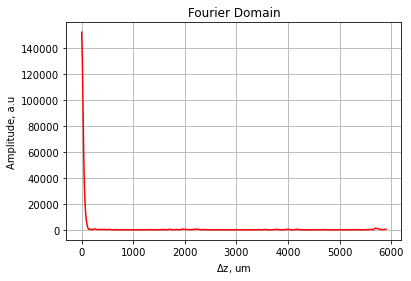

z = 12500


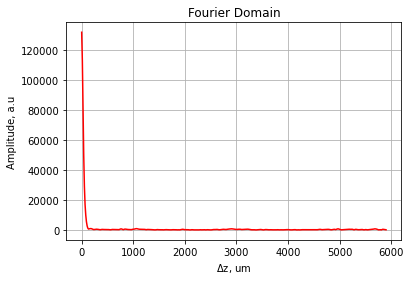

z = 10000


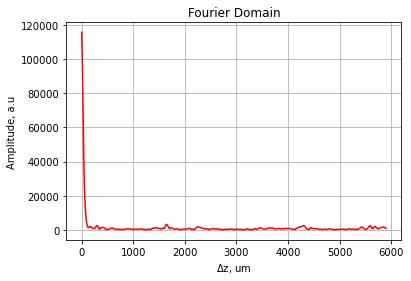

z = 7500


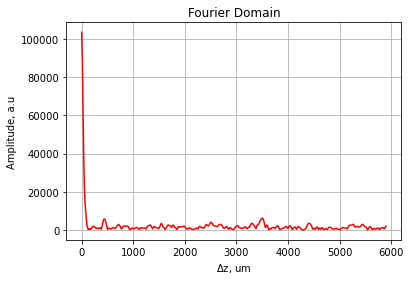

z = 5000


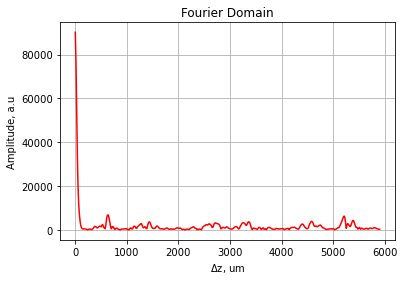

z = 4000


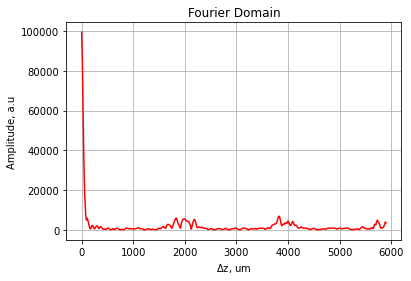

z = 3750


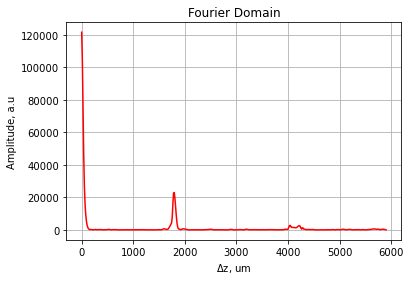

z = 2500


In [56]:
#FFT without division by initial spectrum
spp = np.zeros(1001)+1
for name in files:
    sp = read_spectr(path+name, out_wl=0)
    distance = int(name[:4])
    fourier(wl, spp, sp, 100, 998, out = 0)
    print('z =', 22500 - distance*5)